In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [3]:
### Create function for Cressman Analysis ###
def weights(d,roi):
    if d > roi:
        temp = 0
    else:
        temp = (roi**2 - d**2)/(roi**2 + d**2)
    return temp


In [16]:
### Read in observations ###
aplace = np.loadtxt("RAOBs_201903131200.txt",
                 delimiter=",",usecols=0,dtype='str')
anum = np.genfromtxt("RAOBs_201903131200.txt", delimiter=",", names=("stn","lat", "lon", "hgts", "dir", "spd"))
#display(anum2)
lat = anum['lat']
lon = anum['lon']
height = anum['hgts']

print(height)

[5460. 5540. 5360. 5340. 5220. 5190. 4890. 5210. 5140. 5360. 4970. 5450.
 5180. 5370. 5020. 5490. 5230. 5160. 5180. 5270. 5300. 5250. 5250. 5470.
 5380. 5380. 5430. 5550. 5200. 5710. 5180. 5450. 5660. 5440. 5260. 5420.
 5610. 5780. 5180. 5510. 5820. 5780. 5390. 5840. 5130. 5660. 5760. 5510.
 5100. 5630. 5810. 5810. 5540. 5450. 5680. 5570. 5450. 5680. 5670. 5670.
 5520. 5880. 5280. 5820. 5470. 5640. 5670. 5440. 5430. 5600. 5780. 5590.
 5730. 5730. 5690. 5520. 5810. 5830. 5840. 5840. 5860. 5540. 5820. 5760.
 5400. 5760. 5530. 5880. 5880. 5530. 5780. 5880. 5600. 5800. 5810. 5840.
 5640. 5880. 5640. 5600. 5610. 5610. 5670. 5180. 5390. 5200. 5610. 5690.
 5710. 5490. 5480. 5440. 5660. 5760. 5870. 5880. 5710. 5780. 5850. 5430.
 5480. 5110. 5870. 5410. 5860. 5640. 5570. 5470. 5490. 5470. 5730. 5620.
 5340. 5580. 5340.]


In [5]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x0 = 18.9
y0 = -6.3
xgrid = x0+np.arange(22)*1.27
ygrid = y0+np.arange(28)*1.27 #in southwest corner

x,y = np.meshgrid(xgrid, ygrid, indexing='xy')
#print(alist)

In [28]:
### convert obs lat/long to x,y###
'''
Note: to convert between lat/lon, we use the general equation
 y = m*rho*sigma*cos(phi)*sin(lambda0 - lambda), where rho = avg radius of earth (in cm), phi = lat, lambda = lon, lambda0 = 60N (given), m = map conversion factor, and sigma = ((1+sin(phi0))/(1+sin(phi)))
 x = m*rho*sigma*cos(phi)*cos(lambda0 - lambda)
'''
xobs = np.empty(len(lon))
yobs = np.empty(len(lat))
m = 1/15000000
l = -115*np.pi/180
phi0 = 60*np.pi/180
r = 637100000 #centimeters

for n in np.arange(len(anum)):
    xobs[n] = m*r*((1+np.sin(60*np.pi/180))/(1+np.sin(lat[n]*np.pi/180)))*np.cos(lat[n]*np.pi/180)*np.cos((lon[n]*np.pi/180)-l)
    yobs[n] = m*r*((1+np.sin(60*np.pi/180))/(1+np.sin(lat[n]*np.pi/180)))*np.cos(lat[n]*np.pi/180)*np.sin((lon[n]*np.pi/180)-l)


In [29]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin

### Finding dmin ###
'''
radius = (xobs**2 + yobs**2)**0.5
dmin = sum(radius)/len(radius)
'''
dmin = 0
#radius = np.zeros((len(xobs),len(yobs)))
tdmin = np.empty((len(xobs),len(yobs)))
for i in range(len(xobs)):
    relx = xobs[i] - xobs
    rely = yobs[i] - yobs
    radius = (relx**2 + rely**2)**0.5
    radius = np.delete(radius,i)
    dmin += np.amin(radius)
    
dmin = dmin / len(xobs)

print(dmin)


2.5548700820071426


In [30]:
print(y[0,0],y[1,0],y[0,1])
print(x[0,0],x[1,0],x[0,1])

-6.3 -5.029999999999999 -6.3
18.9 18.9 20.169999999999998


In [31]:
tempx=np.empty(len(xobs))
tempy=np.empty(len(yobs))
radius=np.empty(shape=(len(x[0]),len(x),len(xobs)))

for i in range(len(x[0])):
    for j in range(len(x)):
        radius[i,j] = ( (x[j,i] - xobs)**2 + (y[j,i] - yobs)**2 )**0.5
        #for k in range(len(xobs)):
        #    tempx[k] = x[j,i] - xobs[k]
        #    tempy[k] = y[j,i] - yobs[k]
        #    #determine number of points in ROI
        #    radius[i,j,k] = (tempx[k]**2 + tempy[k]**2)**0.5

w15 = np.zeros(shape=(len(x),len(x[0]),len(xobs)))
w25 = np.zeros(shape=(len(x),len(x[0]),len(xobs)))
w40 = np.zeros(shape=(len(x),len(x[0]),len(xobs)))

for i in range(len(x)):
    for j in range(len(x[0])):
        for k in range(len(xobs)):
            w15[i,j,k] = weights(radius[j,i,k],1.5*dmin)
            w25[i,j,k] = weights(radius[j,i,k],2.5*dmin)
            w40[i,j,k] = weights(radius[j,i,k],4*dmin)  



In [32]:
print(w40)

[[[0.         0.         0.03193635 ... 0.86156523 0.         0.98256519]
  [0.         0.         0.12445385 ... 0.8657058  0.         0.97875964]
  [0.         0.         0.2120729  ... 0.81738328 0.         0.91651364]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.11847882 ... 0.73130256 0.         0.91711325]
  [0.         0.         0.22798819 ... 0.73488337 0.         0.91355459]
  [0.         0.         0.3332403  ... 0.69302395 0.         0.85528291]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.19827272 ... 0.57862947 0.         0.80413644]
  [0.         0.      

In [33]:
### First analysis, no successive corrections ###
'''
fa(ri) = fb(ri) + {SUM(w(ob-an)*[fo(ob loc) - fb(ob loc)]}/[SUM(w(ob-an))]
analysis at analysis point = background at analysis point + {sum of weights*(ob-an)*[obs at obs location - background at obs location]}/
                                                                                    {SUM[weights(ob-an)]}


'''
fa40 = np.zeros(x.shape)
for i in range(len(x[0])):
    for j in range(len(x)):
        fa40[j,i] = sum(w40[j,i]*height)/sum(w40[j,i])


In [34]:
def bilinear(x,y,a):
    tlx = int(np.floor(x))
    tly = int(np.ceil(y))
    trx = int(np.ceil(x))
    tyr = int(np.ceil(y))
    blx = int(np.floor(x))
    bly = int(np.floor(y))
    brx = int(np.ceil(x))
    bry = int(np.floor(y))
    bottom   = a[blx,bly] + (x-blx)*(a[brx,bry] - a[blx,bly])
    top      = a[tlx,tly] + (x-tlx)*(a[trx,tyr] - a[tlx,tly])
    analysis = bottom + (y-bly)*(top-bottom)
    return analysis

In [35]:
indj = np.zeros(len(xobs))
indi = np.zeros(len(xobs))

for i in range(len(xobs)):
    indj[i] = (xobs[i]-x0)/1.27
    indi[i] = (yobs[i]-y0)/1.27

print(x[0,-1],indj)

45.57 [ 4.91825770e+00  2.56884822e+00  5.66273103e+00  4.41190226e-01
 -1.42176831e+00 -3.54323333e+00 -1.01158525e+01 -3.53225347e+00
 -4.86552760e+00 -1.84235331e+00 -1.24154865e+01  3.21612921e+00
 -8.11444428e-01  4.81897768e+00 -7.02058209e+00  3.37967541e-01
  1.80376915e+00 -5.16739688e+00 -2.62708814e+00 -1.49558172e+00
  2.37580586e+00  1.41242926e+00 -2.89810456e+00  6.90196550e+00
 -9.64518360e-03  5.26728985e+00  1.72221666e+01  9.61569779e+00
 -5.48880490e-01  8.73721303e+00 -1.79939466e+00  1.34935347e+01
  5.14687015e+00  1.65788015e+01 -1.74212169e+00  3.96730676e+00
  6.85758436e+00  1.69950462e+01 -3.74614271e+00  9.07935207e+00
  1.41736197e+01  1.30105339e+01  1.18790629e+01  2.23608963e+01
 -7.20988905e+00  7.02362927e+00  1.39317772e+01  1.93920009e+00
 -1.71976558e+00  4.90846607e+00  1.29320415e+01  2.10430302e+01
  1.46547326e+01  1.38411857e+01  2.04768779e+01  1.94971225e+01
  1.39025322e+01  2.05081231e+01  8.39549315e+00  1.06275322e+01
  1.94399362e+01  1

In [36]:
### Next Analyses ###
'''
for each ov location
    if ob is within grid
        Bilinear
    else
        Reverse Cressman
convert xy space to index space
ind-j.ob = obx-minx/delta-x
ind-i.ob = oby-miny/dy

fa(ri) = fb(ri)[IE prev analysis values] + {SUM(fo(rk) - fb(rk)[prev analysis values interpolated using biliear and RC to obs locs]

first obs at x,y=25.14,11.619
indy,indx = 14.109,4.918 <-- round down(np.floor()) both to find bottom left point => 14,4

Bilinear: Bottom  = Fa(bottom-left)+(indx-BL)(fa(bottom-right)-fa(bottom-left))/(delta x)) == fa + (4.9-4) * (analysis value @ 
'''
background = np.zeros(shape=(len(xobs),len(yobs)))
bottom = 0
top = 0

for i in range(len(xobs)):
    for j in range(len(yobs)):
        for k in range(len(x)):
            for l in range(len(x[0])):
                if indj[i] < (len(x)-1) and indj[i] >= 0 and indi[j] < (len(x[0])-1) and indi[j] >= 0: #inside grid, Bilinear
                    tlx = int(np.floor(indj[i]))
                    tly = int(np.ceil(indi[j]))
                    trx = int(np.ceil(indj[i]))
                    tyr = int(np.ceil(indi[j]))
                    blx = int(np.floor(indj[i]))
                    bly = int(np.floor(indi[j]))
                    brx = int(np.ceil(indj[i]))
                    bry = int(np.floor(indi[j]))
                    bottom   = fa40[blx,bly] + (indj[i]-blx)*(fa40[brx,bry] - fa40[blx,bly])
                    top      = fa40[tlx,tly] + (indj[i]-tlx)*(fa40[trx,tyr] - fa40[tlx,tly])
                    background[i,j] = bottom + (indi[j]-bly)*(top-bottom)
                elif ( (xobs[i] - x[k,l])**2 + (yobs[j] - y[k,l])**2 )**0.5 < 4*dmin:
                    background[i,j] = (4**2 - ((xobs[i] - x[k,l])**2 + (yobs[j] - y[k,l])**2))/(4**2 + ((xobs[i] - x[k,l])**2 + (yobs[j] - y[k,l])**2))
                else:
                    background[i,j] = np.nan


print(background) 

[[5471.85464719           nan 5379.00311084 ...           nan
  5547.84956724           nan]
 [5484.82935404           nan 5386.63429936 ...           nan
  5570.97346827           nan]
 [5469.89408663           nan 5379.05803535 ...           nan
  5543.9961829            nan]
 ...
 [5499.00486709           nan 5394.86151491 ...           nan
  5589.66872268           nan]
 [5473.63387728           nan 5380.01655436 ...           nan
  5551.27801862           nan]
 [5500.15340044           nan 5395.48600251 ...           nan
  5591.27576562           nan]]


In [20]:
print(background[20,2])

5387.419060431312


In [37]:
### PASS 2 ###
#fa(ri) = fb(ri)[IE prev analysis values] + {SUM(fo(rk) - fb(rk)[prev analysis values interpolated using biliear and RC to obs locs]
#fa(ri) = fb(ri) + {SUM(w(ob-an)*[fo(ob loc) - fb(ob loc)]}/[SUM(w(ob-an))]

fa25 = np.zeros(x.shape)
for i in range(len(x)):
    for j in range(len(x[0])):
        fa25[i,j] = fa40[i,j] + (sum(w25[i,j]*(height-background[i,j]))/sum(w25[i,j]))

print(fa25)

[[ 5139.86534836            nan  5304.08923226  5202.85012642
   5324.42217811  5398.51296026  5424.89612582  5576.49352174
   5407.7617896             nan  5517.26200477  5449.33719812
   5495.71112636  5570.47563289  5620.69013205            nan
   5712.1041785   5688.55829528  5664.37212264  5892.67701234
   5900.44187502  5793.04360134]
 [ 5122.20359099            nan  5289.44049614  5175.22932612
   5314.23992552  5382.16897641  5405.27258303  5541.60257225
   5381.29378224            nan  5495.15310515  5411.58384867
   5458.07121469  5543.88836892  5588.21671136            nan
   5689.35388472  5660.26779736  5615.02689941  5853.0168
   5871.56669197  5774.67386982]
 [ 5120.02359195            nan  5278.19269549  5183.60458362
   5298.88051314  5368.95006353  5390.26663907  5553.60178644
   5383.12549878            nan  5479.88158929  5416.67444968
   5455.19393571  5520.38334998  5562.23610651            nan
   5668.50574088  5646.78055774  5620.34523506  5856.07231016
   5873.

In [38]:
### PASS 3 ###
fa15 = np.zeros(x.shape)
for i in range(len(x)):
    for j in range(len(x[0])):
        fa15[i,j] = fa25[i,j] + (sum(w15[i,j]*(height-background[i,j]))/sum(w15[i,j]))

print(fa15)

[[ 5000.81566696            nan  5286.44065815  5081.45391643
   5303.85337465  5418.78845961  5452.59822202  5749.66079466
   5392.21147873            nan  5575.67759824  5438.60773886
   5519.66414587  5661.61149568  5770.98076693            nan
   5923.09201027  5840.00601945  5755.79799734  6221.09581694
             nan            nan]
 [ 4945.54628548            nan  5235.63252908  4995.7411695
   5255.88926685  5385.47350836  5416.01566334  5680.0088724
   5349.20954854            nan  5551.51681065  5380.80261324
   5464.45029694  5627.5372781   5718.64643993            nan
   5885.58226815  5811.444802    5709.30344173  6162.0697691
   6170.73792744  5961.51246621]
 [ 4936.20069918            nan  5199.13466014  4996.8574592
   5215.90200599  5346.70597762  5381.78153853  5705.54797853
   5357.65115749            nan  5527.4353683   5400.19905725
   5464.72723896  5586.46587367  5674.04500165            nan
   5839.48890732  5802.90386329  5749.10164169  6190.80463147
   6196.

/tmp/ipykernel_18724/2186301506.py:5: RuntimeWarning: invalid value encountered in scalar divide
  fa15[i,j] = fa25[i,j] + (sum(w15[i,j]*(height-background[i,j]))/sum(w15[i,j]))


In [39]:
### Calculate Analysis Differences
#np.savetxt('RoI-20cm_numObsPerPoint.csv',N_OBS[:,:,1],delimiter=',')
compare12 = np.empty(fa40.shape)
compare13 = np.empty(fa40.shape)
compare23 = np.empty(fa40.shape)

for i in range(len(fa40)):
    for j in range(len(fa40[0])):
        compare12[i,j] = fa40[i,j] - fa25[i,j]
        compare13[i,j] = fa40[i,j] - fa15[i,j]
        compare23[i,j] = fa25[i,j] - fa15[i,j]

np.savetxt('AnalysisDifference1v2.csv',compare12[:,:],delimiter=',')
np.savetxt('AnalysisDifference1v3.csv',compare13[:,:],delimiter=',')
np.savetxt('AnalysisDifference2v3.csv',compare23[:,:],delimiter=',')

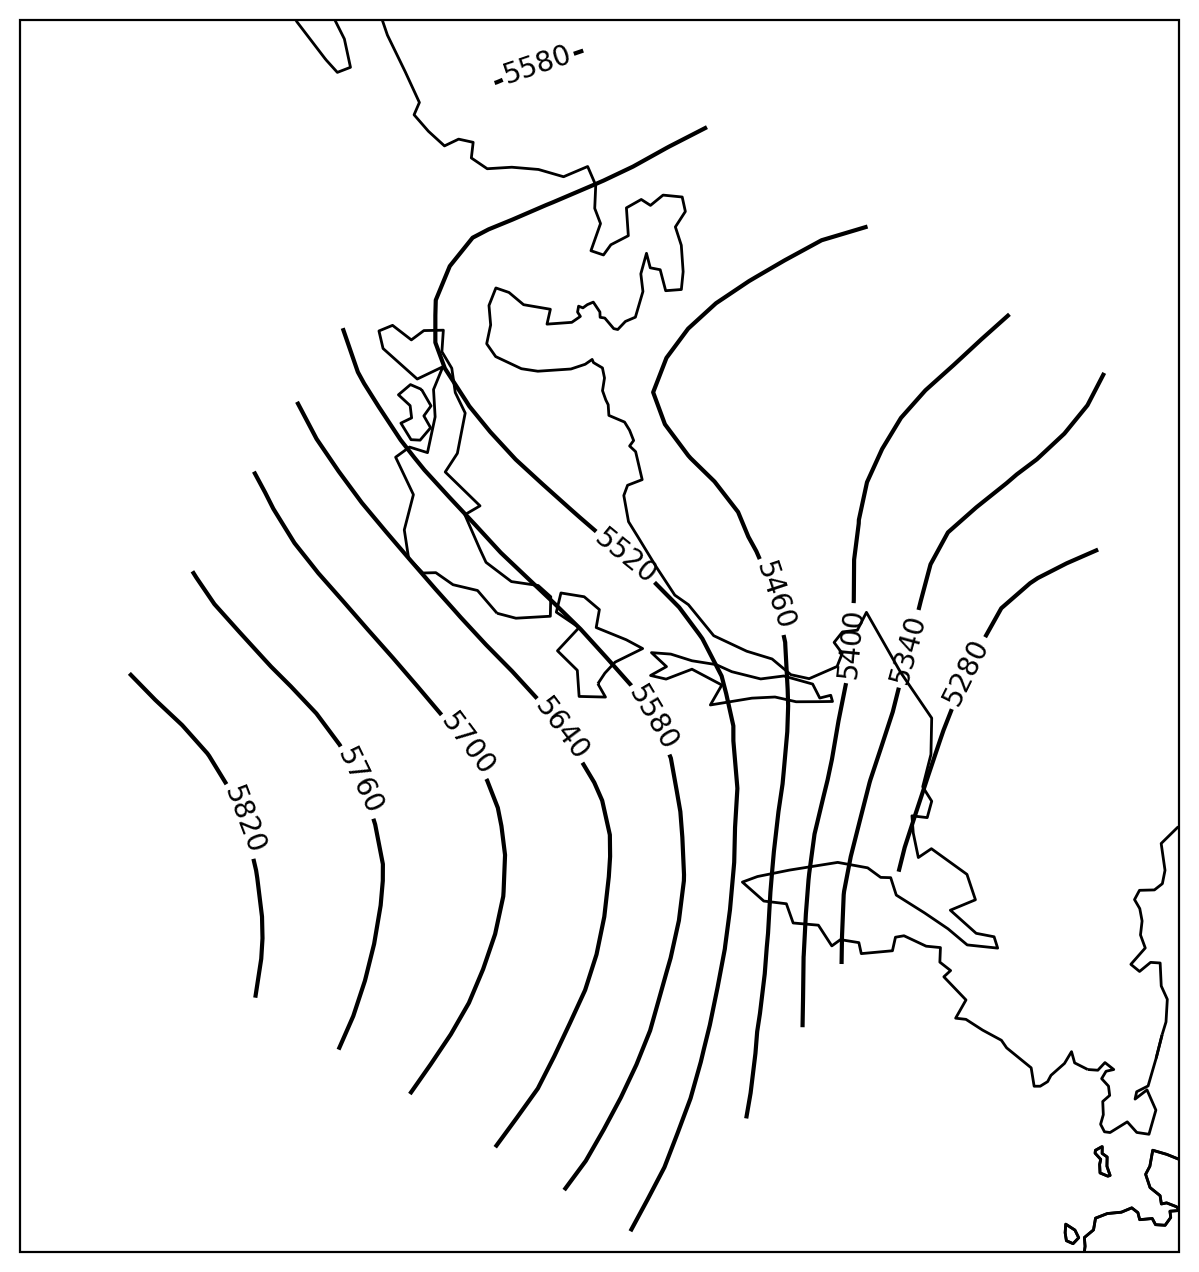

In [40]:
### Plot 500mb analyses over a map ###
#use old code...
LAT = (180/np.pi) * (np.pi/2 - 2*np.arctan((((x/m)**2 + (y/m)**2)**0.5)/(r*(1+np.sin(phi0)))))
LON = (180/np.pi) * (l + np.arctan(y/x))


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,fa40[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()


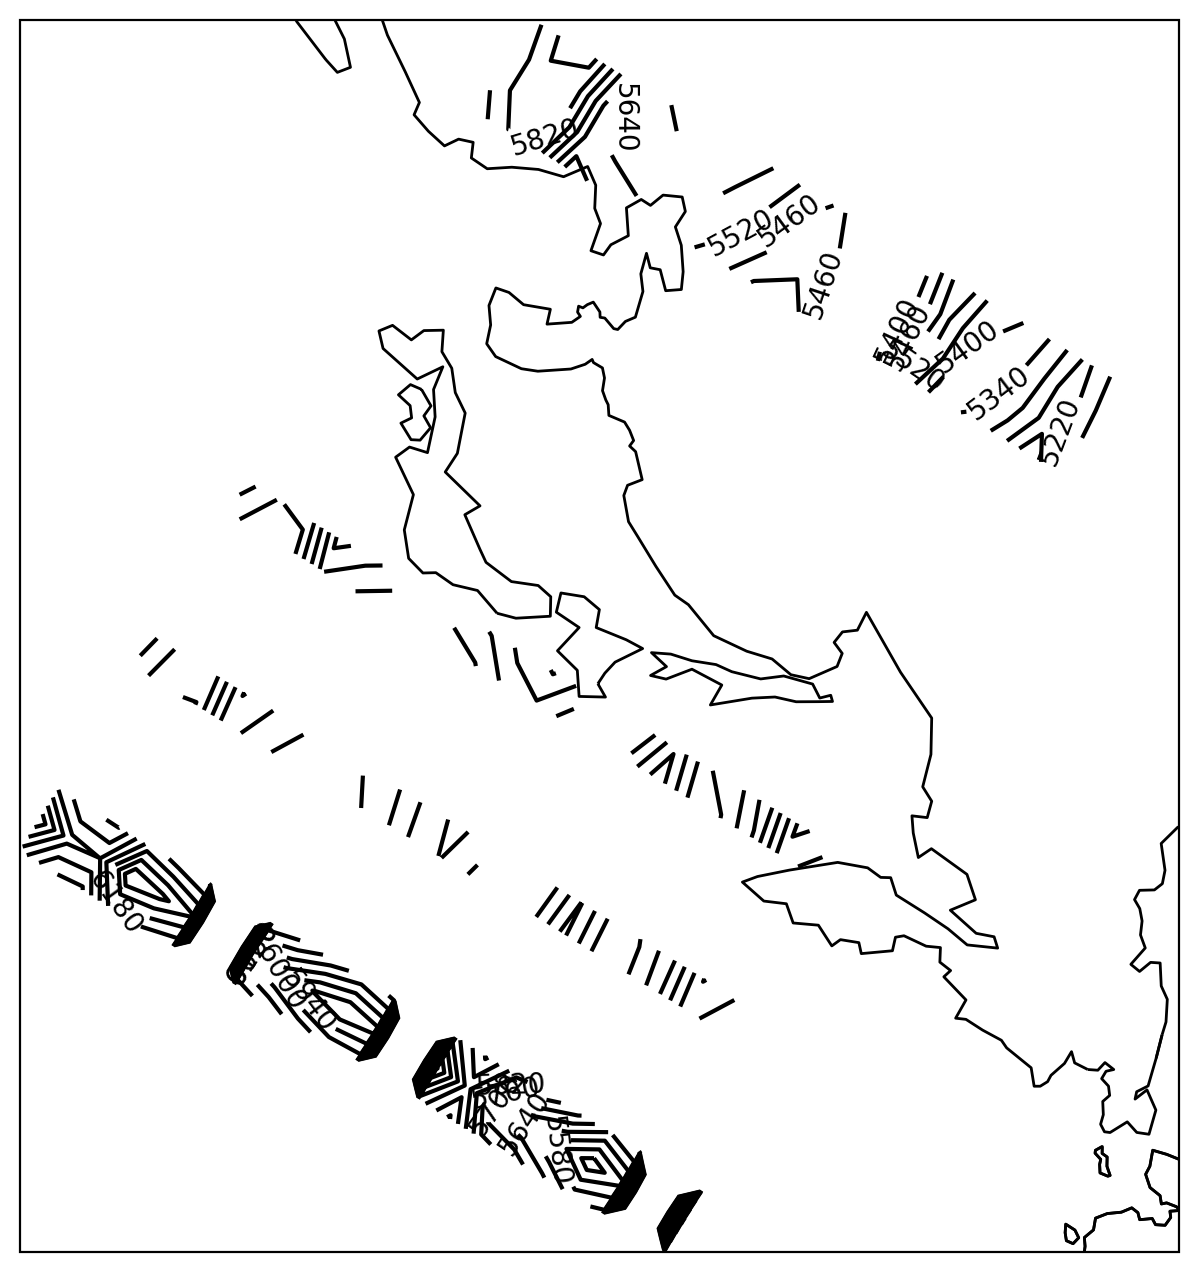

In [41]:
LAT = (180/np.pi) * (np.pi/2 - 2*np.arctan((((x/m)**2 + (y/m)**2)**0.5)/(r*(1+np.sin(phi0)))))
LON = (180/np.pi) * (l + np.arctan(y/x))


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,fa25[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()


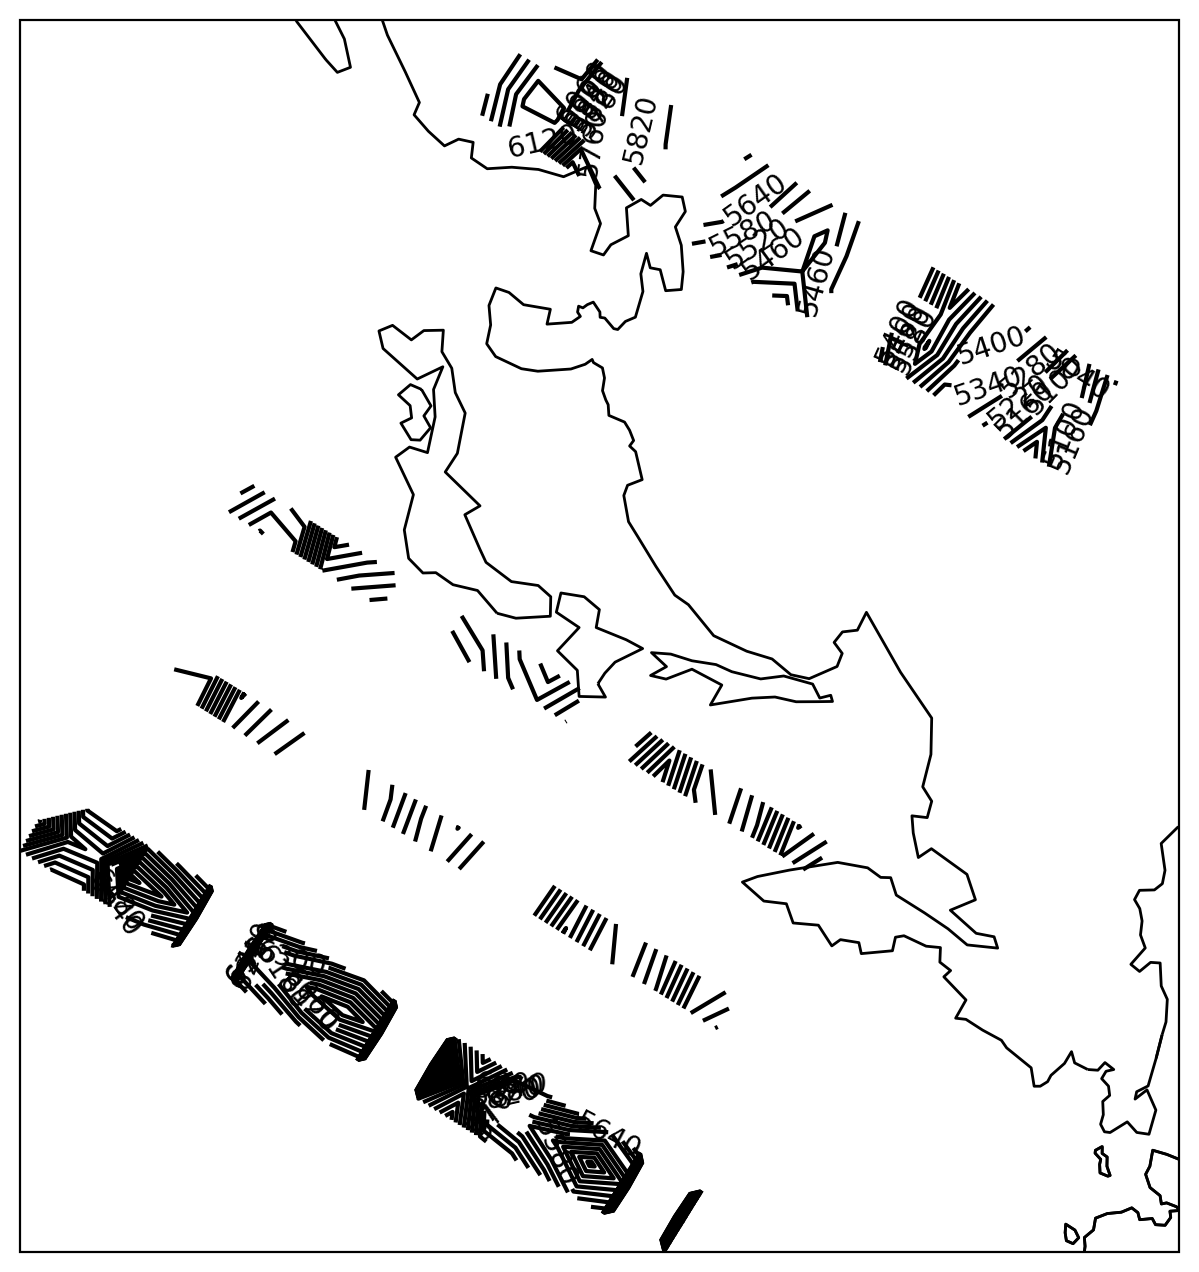

In [42]:
LAT = (180/np.pi) * (np.pi/2 - 2*np.arctan((((x/m)**2 + (y/m)**2)**0.5)/(r*(1+np.sin(phi0)))))
LON = (180/np.pi) * (l + np.arctan(y/x))


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,fa15[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()


In [ ]:
### Plot Analysis Differences ###


In [ ]:
### Store the analyses in text files ###


In [ ]:
### Store the difference fields in text files ###


In [ ]:
### Store RMS values in text file ###


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    

'''